# Can U-Net predict only the evidence?

What exactly _is_ the evidence in the Skyline12 dataset anyways?

It's actually _scribbles_ that _roughly_ indicate the position of building on the image. There is an individual scribble (points that form a path of a brush stroke) for each building. In our case, to make them usable we create white brush stroke (of a set stroke size) on a black canvas of the same dimensions as each corresponding image. So the evidence is actually an image with black and white pixels.

In [10]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

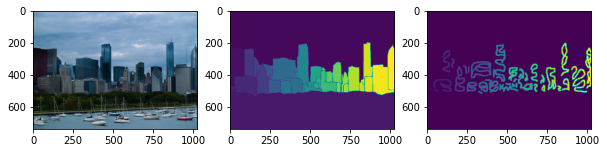

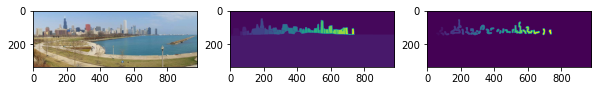

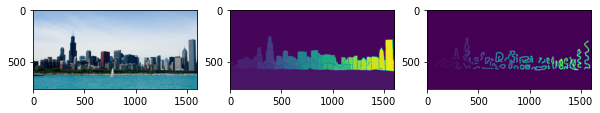

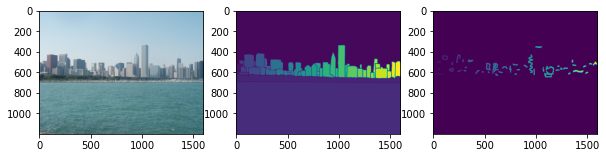

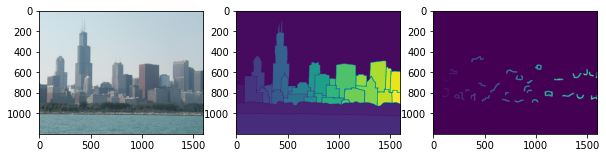

In [11]:
from itertools import islice

for x, y, z in islice(skyline12, 5):
    Skyline12.show_sample(x, [y, z])

As we can see from the small preview of the dataset (ignoring the different colormapping), the scribbles are really sparse. This is expected, as the buildings, at least in the original untampered dataset, take up only a portion of the image. Even so, the density of the drawings vary significantly.

In [30]:
# measuring the class balance
import numpy as np


def get_class_ratio(img):
    img = np.ravel(img)
    pos = img[img > 0]
    neg = img[img == 0]
    return 100 * len(pos)/(len(pos) + len(neg))


class_ratios = np.array([get_class_ratio(z) for _, _, z in skyline12])

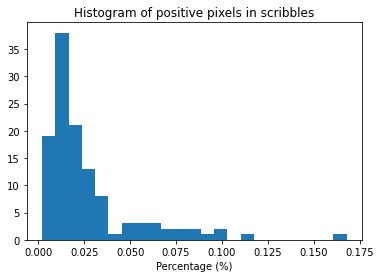

In [37]:
import matplotlib.pyplot as plt

plt.hist(class_ratios, 'auto')
plt.title('Histogram of positive pixels in scribbles')
plt.xlabel('Percentage (%)');

We see that in most of the images in the original Skyline12 dataset, scribbles are less than 2% of the total pixels. That makes it a problem of _class imbalance_ that we need to deal with if we want the model to train fast enough and not spend a number of epochs just to learn to ignore the 0-value pixels. Even worse, it _could_ get trapped in a local minimum, depeding of the loss function and activation that we choose.

In [5]:
def keep_x_binary_z(x, y, z):
    z = tf.squeeze(z, axis=-1)
    z = tf.cast(z, tf.uint8)
    z = tf.one_hot(z, 2)
    return x, z

FOLDS = 2
train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(keep_x_binary_z)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(keep_x_binary_z)

In [1]:
from models.unet import create_unet

unet = create_unet(num_classes=2)
unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
contracting_block_64_conv1 (Con (None, 512, 512, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
contracting_block_64_conv2 (Con (None, 512, 512, 64) 36928       contracting_block_64_conv1[0][0] 
__________________________________________________________________________________________________
contracting_block_64_pool (MaxP (None, 256, 256, 64) 0           contracting_block_64_conv2[0][0] 
_______________________________________________________________________________________________

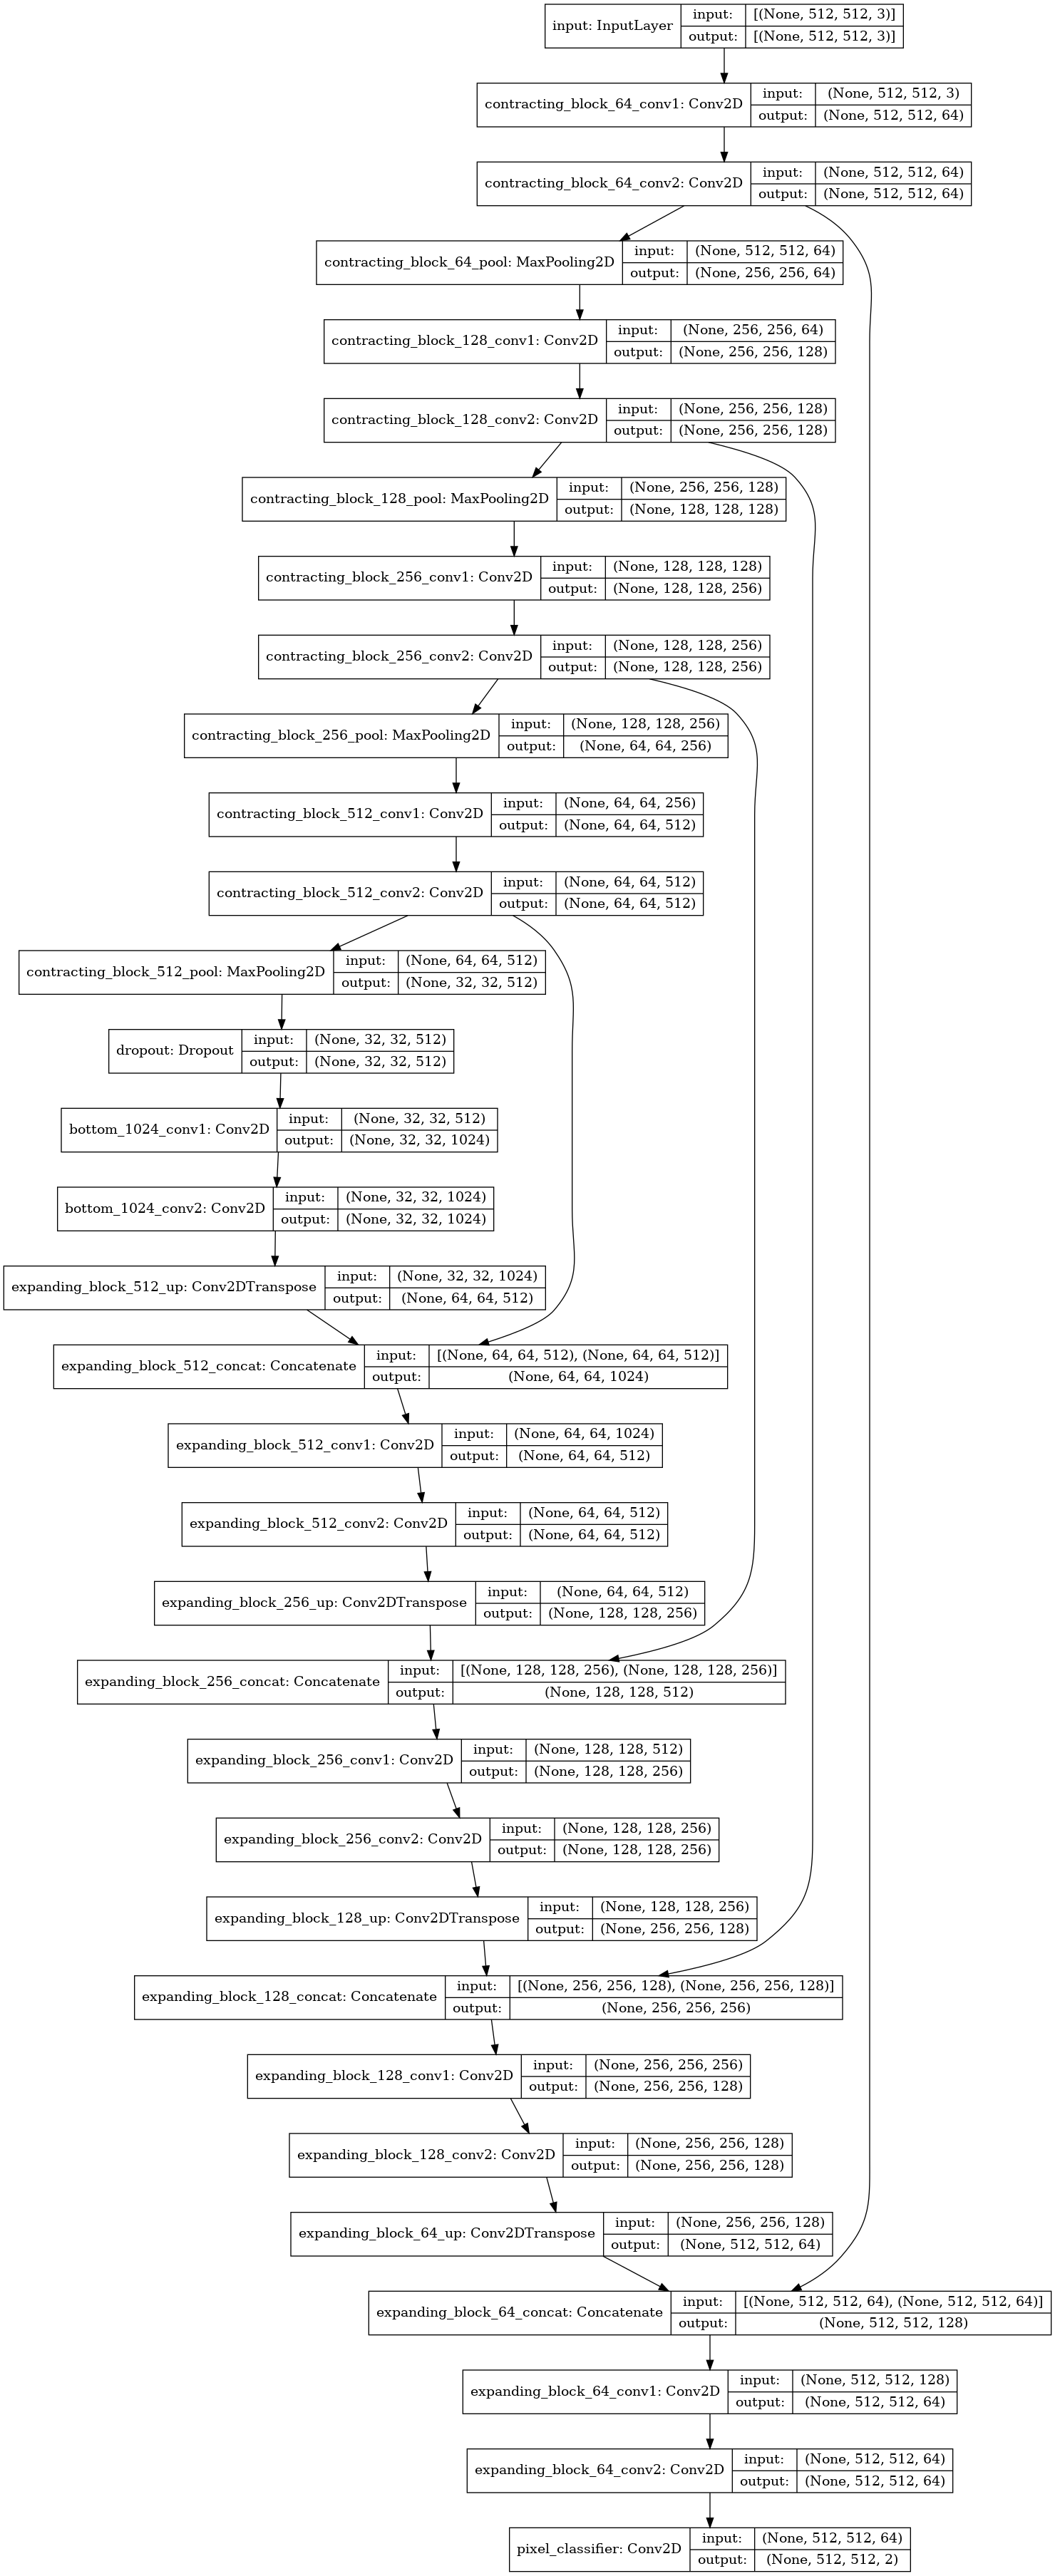

In [2]:
import tensorflow as tf

tf.keras.utils.plot_model(unet, show_layer_names=True, show_shapes=True)

In [3]:
import wandb

wandb.init(project='unet-baseline', config={
    'unet_loss': 'categorical_crossentropy',
    'unet_optimizer': 'adam',
    'unet_learning_rate': 1e-9,
    'batch_size': 3,
})
hparams = wandb.config

/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B is disabled in this directory.  Run `wandb on` to enable cloud syncing.


In [4]:
from metrics import CategoricalMeanIou

unet.compile(
    loss=hparams['unet_loss'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=hparams['unet_learning_rate']),
    metrics=[CategoricalMeanIou(num_classes=2), 'accuracy']
)

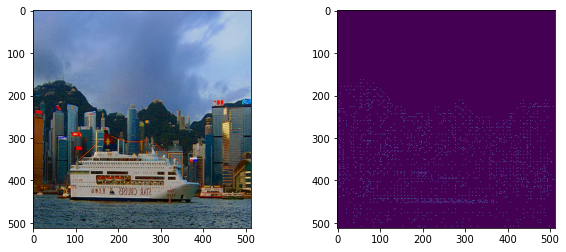

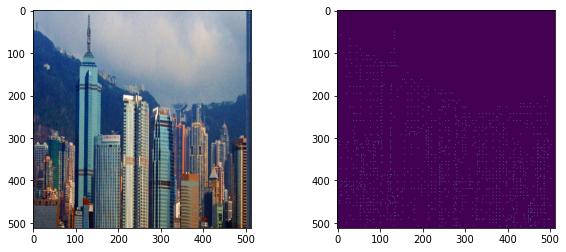

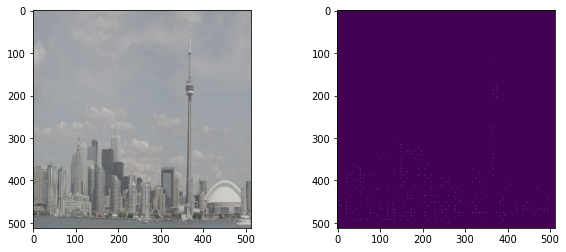

In [6]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = unet(batch_x, training=False)

for x, y_pred in zip(batch_x, preds):
    Skyline12.show_sample(x, [y_pred], from_tensors=True)

In [7]:
!mkdir -p logs
from tensorflow.keras.callbacks import \
    TerminateOnNaN, TensorBoard, EarlyStopping, ModelCheckpoint
from utils import get_new_logdir
from tensorflow.data.experimental import AUTOTUNE
from os.path import join
from callbacks import LogImages, LogImagesWandb
from wandb.keras import WandbCallback

log_dir = get_new_logdir(root_dir='./logs')
batch_size = hparams['batch_size']
unet.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=5,
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE),
    callbacks=[
        EarlyStopping(patience=10),
        TerminateOnNaN(),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        ),
        ModelCheckpoint(
            join(log_dir, 'model-best.h5'),
            save_best_only=True,
            save_weights_only=True
        ),
        LogImages(log_dir, next(iter(val_ds.batch(10)))),
        LogImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/5
      6/Unknown - 9s 426ms/step - loss: 0.3156 - categorical_mean_iou: 0.4660 - accuracy: 0.9246WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1145s vs `on_train_batch_end` time: 0.2212s). Check your callbacks.
80/80 [==============================] - 37s 381ms/step - loss: 0.2879 - categorical_mean_iou: 0.4751 - accuracy: 0.9443 - val_loss: 0.2886 - val_categorical_mean_iou: 0.4773 - val_accuracy: 0.9491
Epoch 2/5
80/80 [==============================] - 27s 342ms/step - loss: 0.2878 - categorical_mean_iou: 0.4751 - accuracy: 0.9443 - val_loss: 0.2885 - val_categorical_mean_iou: 0.4773 - val_accuracy: 0.9491
Epoch 3/5
80/80 [==============================] - 27s 343ms/step - loss: 0.2877 - categorical_mean_iou: 0.4751 - accuracy: 0.9444 - val_loss: 0.2884 - val_categorical_mean_iou: 0.4773 - val_accuracy: 0.9492
Epoch 4/5
80/80 [==============================] - 27s 342ms/step - loss: 0.2875 - categorical_mean_iou: 0

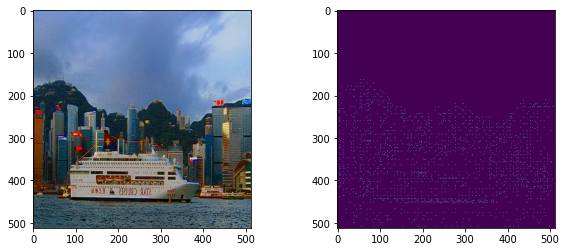

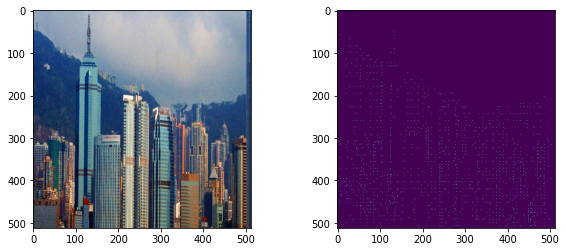

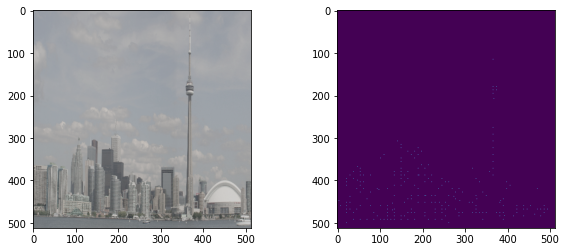

In [8]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = unet(batch_x, training=False)

for x, y_pred in zip(batch_x, preds):
    Skyline12.show_sample(x, [y_pred], from_tensors=True)

In [9]:
wandb.run.finish()

epoch,4
loss,0.27854
categorical_mean_iou,0.47688
accuracy,0.94843
val_loss,0.28811
val_categorical_mean_iou,0.47728
val_accuracy,0.94923
_step,4
_runtime,207
_timestamp,1603399106
best_val_loss,0.28811


epoch,▁▃▅▆█
loss,█▆▅▃▁
categorical_mean_iou,▂█▂▃▁
accuracy,▁▂▄▆█
val_loss,█▆▄▃▁
val_categorical_mean_iou,█▇▅▃▁
val_accuracy,▁▃▅▆█
_step,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▅▆█


wandb: You can sync this run to the cloud by running:
wandb: wandb sync wandb/offline-run-20201022_203459-2d7zcgit
